# $\chi^2$ fit with Chase+2017

## In this Notebook we explore the Chase+2017 approach to analyzing IOPs

## Specifically, we perform multi-Gaussian fits to absorption spectra

## We find the solutions "blow-up", i.e. the covariance matrix is ill-defined

In [10]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from ocpy.utils import plotting
from bing.models import anw as bing_anw

import anly_utils
import fit_anw

In [2]:
%matplotlib ipympl

# defs

In [3]:
def show_fit(model, model_anw, p0, fit_lbl):
    fig = plt.figure(figsize=(7,5))
    ax = plt.gca()
    ax.plot(model.wave, model.eval_anw(p0).flatten(), 'b-', label=fit_lbl)
    ax.plot(model.wave, model_anw, 'k-', label='True')
    ax.legend(fontsize=15.)
    # 
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel(r'$a_{\rm nw} \; \rm [m^{-1}]$')
    plotting.set_fontsize(ax, 17)
    plt.show()

# Fit with a constrained version of the Chase+2017 model

## Under the hood, the code:

1. Loads up the Loisel+2023 spectrum with the index given (the first example is 170)
2. Processes to a given satellite, as desired (we use the L23 data as is here)
3. Preps the model
4. Fits with MCMC or $\chi^2$.  Here we use $\chi^2$ to keep it simple
5. Returns the solution

## Load the model to inspect it

In [13]:
mini_name = 'Chase2017Mini'
mini_model = bing_anw.init_model(mini_name, np.linspace(350., 700, 350))
#
mini_model.nparam

12

In [14]:
mini_model.pnames

['CNAP',
 'SNAP',
 'CCDOM',
 'SCDOM',
 'aph384',
 'aph413',
 'aph435',
 'aph461',
 'aph464',
 'aph490',
 'aph532',
 'aph583']

## 12 parameters: 

### 2 each for NAP and CDOM

### One amplitude for each of the 8 Gaussians

In [18]:
reload(fit_anw)
#model, model_anw, p0, ans, cov = fit_anw.fit('Chase2017', 170, None,True use_chisq=True, max_wave=600.)
model, model_anw, p0, ans, cov = fit_anw.fit(
    'Chase2017Mini', 170, None,
    show=False, use_chisq=True, nsteps=20000, max_wave=600.,
    abs_noise=0.005, chk_guess=False, min_wave=400.)

## We remind ourselves that the NAP and CDOM components are both exponentials

### For NAP, the shape parameter is forced to lie in the interval $S_{\rm NAP} = [0.005, 0.016]$

### For CDOM, the shape parameter is $S_{\rm CDOM} = [0.005, 0.02]$

# Show the initial guess

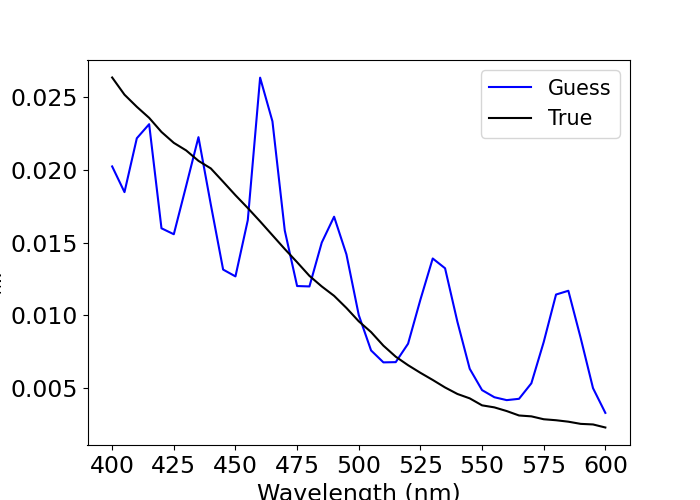

In [19]:
show_fit(model, model_anw, p0, 'Guess')

# Show the fit

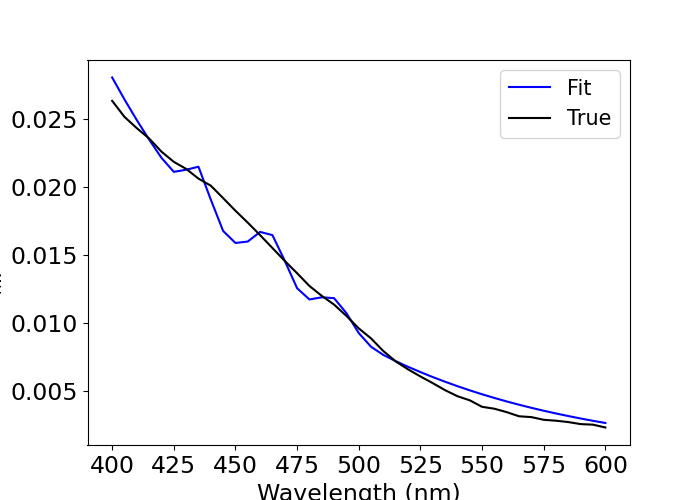

In [20]:
show_fit(model, model_anw, ans, 'Fit')

# At this level of inspection, all looks well and good

## But the devil is in the details, or really in the error estimates..

## Let's examine the covariance matrix generated by the LM ($\chi^2$) fitting

## Diagonal

In [21]:
perr = np.sqrt(np.diag(cov))
perr

array([7.63261866e+06, 9.68374737e+02, 4.59187532e+06, 6.89043131e+02,
       5.22022027e+03, 3.40291117e+02, 1.67389044e-01, 3.71004102e+02,
       2.14240189e-01, 1.92677874e-01, 3.49334039e+02, 3.82884041e+02])

## Percent error

In [22]:
perc_err = np.abs(100*perr / ans)
perc_err

array([3.86143436e+08, 5.02958513e+04, 2.61504602e+08, 3.57869922e+04,
       8.70043111e+04, 6.04550775e+03, 6.62468150e+00, 6.52072395e+03,
       8.73341674e+00, 7.23293167e+00, 5.82748878e+03, 6.38579529e+03])

In [ ]:
## Yes, that is $10^8$% error for several of these and $10^3$ for others

## We should have anticipated that the NAP and CDOM components would be highly uncertain because they 

## Show the covariance array

/tmp/ipykernel_1542876/2038748389.py:3: RuntimeWarning: invalid value encountered in log10
  img = ax.imshow(np.log10(cov))


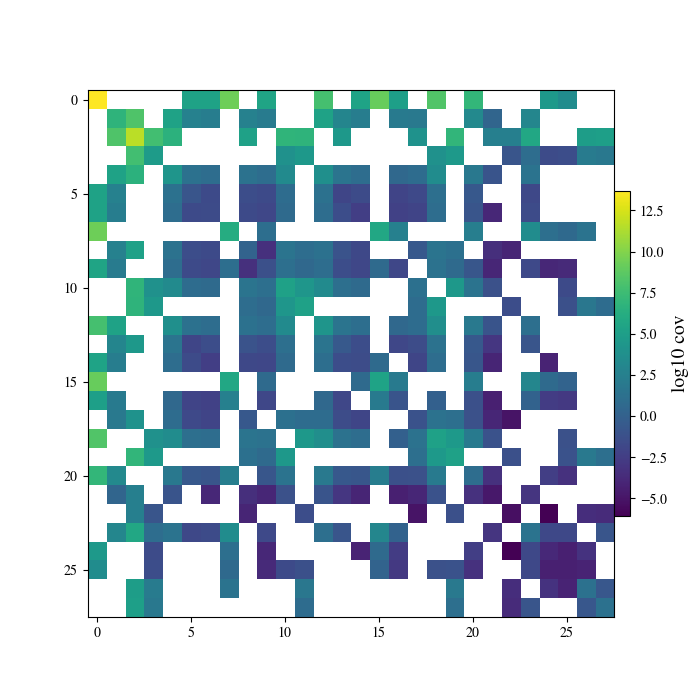

In [28]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
img = ax.imshow(np.log10(cov))
cbaxes = plt.colorbar(img, pad=0., fraction=0.030)
cbaxes.set_label('log10 cov', fontsize=14)
#
plt.show()